In [217]:
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import datetime as dt
import pandas as pd
pd.options.display.max_columns = None

In [2]:
url = 'http://gbfs.citibikenyc.com/gbfs/gbfs.json'
response = requests.get(url)

In [3]:
citibike_feed = json.loads(response.text)['data']['en']['feeds']
feed_dict = {i['name']:i['url'] for i in citibike_feed}
feed_dict['bike_angels'] = 'https://layer.bicyclesharing.net/map/v1/nyc/stations'
print(feed_dict)

regions_raw = json.loads(requests.get(feed_dict['system_regions']).text)['data']['regions']
#reformat region
regions = {}
for region in regions_raw:
    regions[region['region_id']] = region['name']

{'system_information': 'https://gbfs.citibikenyc.com/gbfs/en/system_information.json', 'station_information': 'https://gbfs.citibikenyc.com/gbfs/en/station_information.json', 'station_status': 'https://gbfs.citibikenyc.com/gbfs/en/station_status.json', 'free_bike_status': 'https://gbfs.citibikenyc.com/gbfs/en/free_bike_status.json', 'system_hours': 'https://gbfs.citibikenyc.com/gbfs/en/system_hours.json', 'system_calendar': 'https://gbfs.citibikenyc.com/gbfs/en/system_calendar.json', 'system_regions': 'https://gbfs.citibikenyc.com/gbfs/en/system_regions.json', 'system_alerts': 'https://gbfs.citibikenyc.com/gbfs/en/system_alerts.json', 'bike_angels': 'https://layer.bicyclesharing.net/map/v1/nyc/stations'}


In [4]:
def station_initalize():
    """
    Initalizes DataFrame of stations with most current information
    """
    #requests and reads json from CitiBike
    station_information = json.loads(requests.get(feed_dict['station_information']).text)['data']['stations']
    station_status = json.loads(requests.get(feed_dict['station_status']).text)['data']['stations']
    angels = json.loads(requests.get(feed_dict['bike_angels']).text)['features']
    
    #convert to dataframe
    status_df = pd.DataFrame(station_status)
    stations_df = pd.DataFrame(station_information)

    angels_df = pd.DataFrame([i['properties'] for i in angels])
    angels_df = angels_df[['station_id','bike_angels_action', 'bike_angels_points',
           'bike_angels_digits']]

    #join into one dataframe
    df = pd.merge(stations_df,status_df,on='station_id')
    df = pd.merge(df,angels_df,on='station_id')
    df.drop(labels=list(df.loc[df.station_status == 'out_of_service'].index), inplace=True)
    
    df.station_id = df.station_id.astype(int)

    #give direction to bike angle point valies
    conditions = [
        df.bike_angels_action.isna() == True,
        df.bike_angels_action == 'neutral',
        df.bike_angels_action == 'give',
        df.bike_angels_action == 'take',
    ]

    choices = [0,0,df.bike_angels_points,df.bike_angels_points*(-1)]

    df.bike_angels_points = np.select(conditions,choices,df.bike_angels_points)

    #stations_df.set_index('station_id',inplace=True)
    df.rename(columns={'name':'station_name'},inplace=True)
    
    return df

In [20]:
current_df = station_initalize()
current_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1203 entries, 0 to 1208
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   station_name                    1203 non-null   object 
 1   lat                             1203 non-null   float64
 2   short_name                      1203 non-null   object 
 3   legacy_id_x                     1203 non-null   object 
 4   rental_url                      1203 non-null   object 
 5   station_id                      1203 non-null   int64  
 6   electric_bike_surcharge_waiver  1203 non-null   bool   
 7   capacity                        1203 non-null   int64  
 8   station_type                    1203 non-null   object 
 9   eightd_has_key_dispenser        1203 non-null   bool   
 10  eightd_station_services         1203 non-null   object 
 11  has_kiosk                       1203 non-null   bool   
 12  region_id                       12

In [190]:
current_df.head()

,station_name,lat,short_name,legacy_id_x,rental_url,station_id,electric_bike_surcharge_waiver,capacity,station_type,eightd_has_key_dispenser,eightd_station_services,has_kiosk,region_id,rental_methods,external_id,lon,is_renting,legacy_id_y,num_bikes_disabled,num_bikes_available,eightd_has_available_keys,num_docks_available,is_installed,num_docks_disabled,last_reported,num_ebikes_available,is_returning,station_status,bike_angels_action,bike_angels_points,bike_angels_digits
0,W 52 St & 11 Ave,40.767272,6926.01,72,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,72,False,55,classic,False,[],True,71,"[CREDITCARD, KEY]",66db237e-0aca-11e7-82f6-3863bb44ef7c,-73.993929,1,72,0,11,False,44,1,0,1607136555,0,1,active,give,1.0,1.0
1,Franklin St & W Broadway,40.719116,5430.08,79,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,79,False,33,classic,False,[],True,71,"[CREDITCARD, KEY]",66db269c-0aca-11e7-82f6-3863bb44ef7c,-74.006667,1,79,1,16,False,16,1,0,1607137274,1,1,active,take,-1.0,1.0
2,St James Pl & Pearl St,40.711174,5167.06,82,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,82,False,27,classic,False,[],True,71,"[CREDITCARD, KEY]",66db277a-0aca-11e7-82f6-3863bb44ef7c,-74.000165,1,82,1,23,False,3,1,0,1607133613,0,1,active,take,-1.0,1.0
3,Atlantic Ave & Fort Greene Pl,40.683826,4354.07,83,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,83,False,62,classic,False,[],True,71,"[CREDITCARD, KEY]",66db281e-0aca-11e7-82f6-3863bb44ef7c,-73.976323,1,83,0,52,False,10,1,0,1607131720,1,1,active,neutral,0.0,0.0
4,W 17 St & 8 Ave,40.741776,6148.02,116,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,116,False,49,classic,False,[],True,71,"[CREDITCARD, KEY]",66db28b5-0aca-11e7-82f6-3863bb44ef7c,-74.001497,1,116,0,22,False,27,1,0,1607133391,2,1,active,take,-1.0,1.0


In [8]:
#read trips
trips = pd.read_csv('./trip_data/201805-citibike-tripdata.csv')
#rename columns
cols = [col.replace(" ","_") for col in trips.columns]
trips.columns = cols

#change times to datetime objects
trips.starttime = pd.to_datetime(trips.starttime, format='%Y-%m-%d %H:%M:%S.%f')
trips.stoptime = pd.to_datetime(trips.starttime, format='%Y-%m-%d %H:%M:%S.%f')

# multihierarchical index time series 
ts_starts_df = trips.set_index(['start_station_id','starttime']).sort_values(['start_station_id','starttime'])
ts_ends_df = trips.set_index(['end_station_id','stoptime']).sort_values(['end_station_id','stoptime'])

In [74]:
# read historical station data
filepaths = ['./station_data/bikeshare_nyc_raw_jan2018.csv',
            './station_data/bikeshare_nyc_raw_feb2018.csv',
            './station_data/bikeshare_nyc_raw_mar2018.csv',
            './station_data/bikeshare_nyc_raw_apr2018.csv',
            './station_data/bikeshare_nyc_raw_may2018.csv',
            './station_data/bikeshare_nyc_raw_June_2018.csv',
            './station_data/bikeshare_nyc_raw_july2018.csv',
            './station_data/bikeshare_nyc_raw_Aug2018.csv',
            './station_data/bikeshare_nyc_raw_Sept2018.csv',
            './station_data/bikeshare_nyc_raw_oct2018.csv',
            './station_data/bikeshare_nyc_raw_Nov2018.csv',
            './station_data/bikeshare_nyc_raw_dec2018.csv']

station_dfs = [pd.read_csv(path,delimiter='\t', dtype= {'minute':str,'hour':str,'date':str}) for path in filepaths ]

ts_stations = pd.concat(station_dfs)

# rename columns
ts_stations.rename(columns={'dock_id':'station_id','dock_name':'station_name'},inplace=True)

#assign am/pm
ts_stations.pm = np.where(ts_stations.pm == 1, 'PM','AM')

#convert to datetime objects
ts_stations.minute = ts_stations.minute.map(lambda x:x.zfill(2))
ts_stations.hour = ts_stations.hour.map(lambda x:x.zfill(2))
ts_stations['date_time'] = ts_stations.apply(lambda x: x['date'] + " " + str(x['hour']) + ":" + str(x['minute']) + x['pm'],
                                                   axis=1)
ts_stations.date_time = pd.to_datetime(ts_stations.date_time, format='%y-%m-%d %I:%M%p') 

#add percent_full
ts_stations['percent_full'] = ts_stations.avail_bikes/ts_stations.tot_docks

#add seasons
ts_stations['month'] = ts_stations.date_time.map(lambda x:x.month)

def season(x):
    if x >=3 and x <=5:
        return 'spring'
    elif x >=6 and x <=8:
        return 'summer'
    elif x >=9 and x <=11:
        return 'fall'
    else:
        return 'winter'

ts_stations['season'] = ts_stations.month.map(lambda x:season(x))



#multihierarchical index times series
ts_stations.set_index(['station_id','date_time'],inplace=True)
ts_stations.sort_values(['station_id','date_time'],inplace=True)

#drop uneeded cols
ts_stations.drop(columns=['month','pm','hour','minute','date'],inplace=True)

In [55]:
import pickle


In [60]:

pickle_out = open('staions_2018.pickel','wb')
pickle.dump(ts_stations,pickle_out)
pickle_out.close()

In [78]:
ts_stations

station_name      date  \
station_id date_time                                                            
72         2018-01-01 00:26:00                     W 52 St & 11 Ave  18-01-01   
           2018-01-01 00:59:00                     W 52 St & 11 Ave  18-01-01   
           2018-01-01 01:32:00                     W 52 St & 11 Ave  18-01-01   
           2018-01-01 02:04:00                     W 52 St & 11 Ave  18-01-01   
           2018-01-01 02:38:00                     W 52 St & 11 Ave  18-01-01   
...                                                             ...       ...   
3530       2018-12-17 19:04:00           Crescent St & Ditmars Blvd  18-12-17   
           2018-12-17 19:54:00           Crescent St & Ditmars Blvd  18-12-17   
3629       2018-09-08 11:24:00  Adam Clayton Powell Blvd & W 126 St  18-09-08   
           2018-09-08 12:00:00  Adam Clayton Powell Blvd & W 126 St  18-09-08   
           2018-09-08 12:37:00  Adam Clayton Powell Blvd & W 126 St  18-09-08   

                               hour minute  pm  avail_bikes  avail_docks  \
station_id date_time                                                       
72         2018-01-01 00:26:00   12     26  AM           13           26   
           2018-01-01 00:59:00   12     59  AM           13           26   
           2018-01-01 01:32:00   01     32  AM           13           26   
           2018-01-01 02:04:00   02     04  AM           13           26   
           2018-01-01 02:38:00   02     38  AM           13           26   
...                             ...    ...  ..          ...          ...   
3530       2018-12-17 19:04:00   07     04  PM            0           19   
           2018-12-17 19:54:00   07     54  PM            0           19   
3629       2018-09-08 11:24:00   11     24  AM           17           15   
           2018-09-08 12:00:00   12     00  PM           17           15   
           2018-09-08 12:37:00   12     37  PM           19           12   

                                tot_docks       _lat      _long  in_service  \
station_id date_time                                                          
72         2018-01-01 00:26:00         39  40.767272 -73.993929           1   
           2018-01-01 00:59:00         39  40.767272 -73.993929           1   
           2018-01-01 01:32:00         39  40.767272 -73.993929           1   
           2018-01-01 02:04:00         39  40.767272 -73.993929           1   
           2018-01-01 02:38:00         39  40.767272 -73.993929           1   
...                                   ...        ...        ...         ...   
3530       2018-12-17 19:04:00         19  40.778718 -73.914564           1   
           2018-12-17 19:54:00         19  40.778718 -73.914564           1   
3629       2018-09-08 11:24:00         33  40.809495 -73.947765           1   
           2018-09-08 12:00:00         33  40.809495 -73.947765           1   
           2018-09-08 12:37:00         33  40.809495 -73.947765           1   

                                status_key  percent_full  month  season  
station_id date_time                                                     
72         2018-01-01 00:26:00           1      0.333333      1  winter  
           2018-01-01 00:59:00           1      0.333333      1  winter  
           2018-01-01 01:32:00           1      0.333333      1  winter  
           2018-01-01 02:04:00           1      0.333333      1  winter  
           2018-01-01 02:38:00           1      0.333333      1  winter  
...                                    ...           ...    ...     ...  
3530       2018-12-17 19:04:00           1      0.000000     12  winter  
           2018-12-17 19:54:00           1      0.000000     12  winter  
3629       2018-09-08 11:24:00           1      0.515152      9    fall  
           2018-09-08 12:00:00           1      0.515152      9    fall  
           2018-09-08 12:37:00           1      0.575758      9    fall  

[7385008 rows x 15 co

In [179]:
search_station_id('74')

,station_name,station_id
373,W 74 St & Columbus Ave,3172
517,E 74 St & 1 Ave,3372
1145,Washington Ave & E 174 St,4160
1146,3 Ave & E 174 St,4161
1149,E 174 St & Longfellow Ave,4164
1179,E 174 St & Walton Ave,4200


In [186]:
ex_time_series = ts_stations.loc[3172].avail_bikes.resample('H').mean()['2018-06-17':'2018-06-30']

In [284]:
ex_ts_station = Station(3172)


Dickey-Fuller test: 

Test Statistic                  -3.527161
p-value                          0.007316
#Lags Used                      14.000000
Number of Observations Used    321.000000
Critical Value (1%)             -3.450887
Critical Value (5%)             -2.870586
Critical Value (10%)            -2.571590
dtype: float64

Stationary: p-value 0.007316325054456452 < 0.05


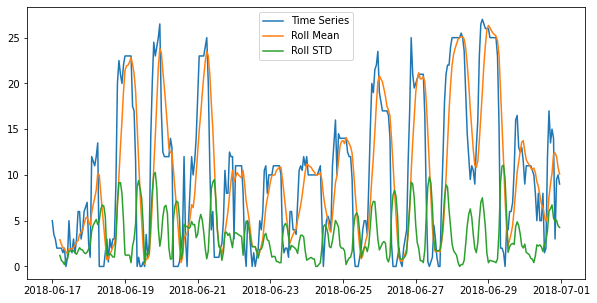

In [275]:
roll_mean, roll_std, ax, dftest = ex_ts_station.availbike_stationarity(time_interval=('2018-06-17','2018-06-30'))

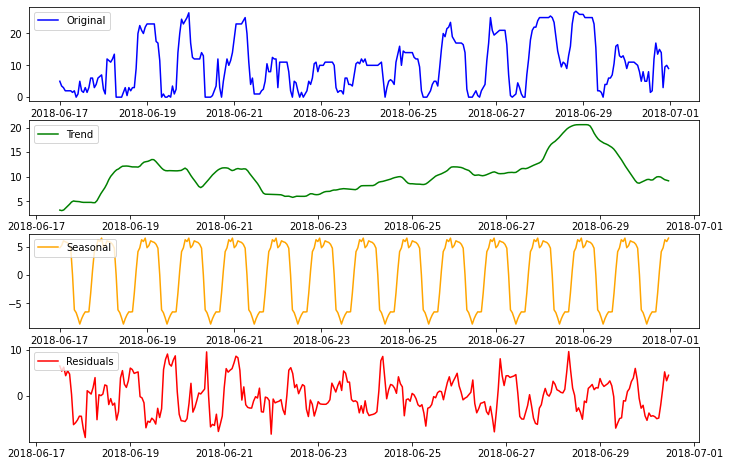

In [277]:
decompose = ex_ts_station.availbike_decompose(time_interval=('2018-06-17','2018-06-30'))

In [188]:
ex_time_series.describe()

count    336.000000
mean      10.126488
std        8.008647
min        0.000000
25%        3.000000
50%       10.000000
75%       15.125000
max       27.000000
Name: avail_bikes, dtype: float64

In [287]:
ts = ex_ts_station.avail_bikes_ts()['2018-06-17':'2018-06-30']

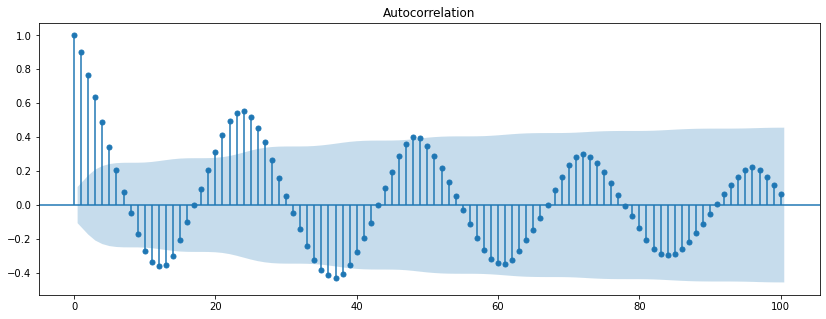

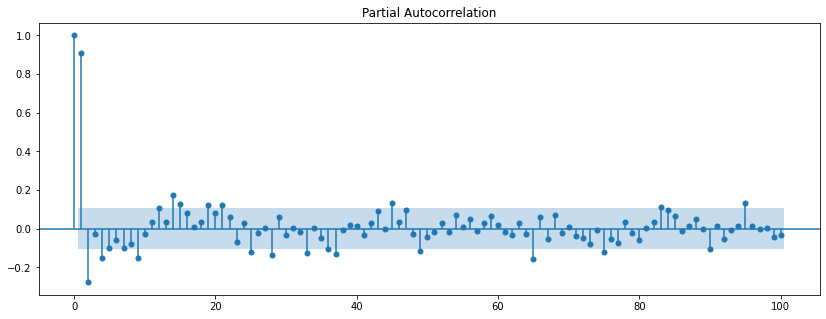

In [290]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_acf(ex_time_series, lags=100);
plot_pacf(ex_time_series, lags=100);

<AxesSubplot:xlabel='date_time'>

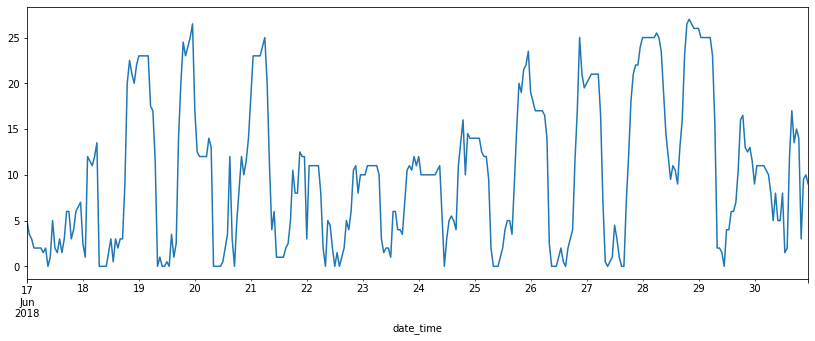

In [325]:
ex_time_series.plot()

In [345]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels as sm
import itertools

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

np.random.seed(7)


#Generate combinations of the number of AR(p), MA(q), and Differencing (q) terms
p = d = q = range(0,4)
pdq = list(itertools.product(p,d,q))
pdqs = [(x[0], x[1], x[2]) for x in pdq]

##grid search parameters using generated list of combinations

models=[]
for comb in pdqs:
    try:
        arima = ARIMA(ex_time_series, order=comb,enforce_invertibility=False,enforce_stationarity=False)
        model = arima.fit()
        arima.fit()
        models.append([comb,combs,model.aic])
    except:
        continue
            
models_df = pd.DataFrame(models, columns=['pdq', 'pdqs', 'aic'])
models_df.sort_values('aic')

/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:56

,pdq,pdqs,aic
51,"(3, 0, 3)","(3, 3, 3)",1719.188841
35,"(2, 0, 3)","(3, 3, 3)",1732.629321
34,"(2, 0, 2)","(3, 3, 3)",1739.222865
50,"(3, 0, 2)","(3, 3, 3)",1739.418228
49,"(3, 0, 1)","(3, 3, 3)",1740.336202
...,...,...,...
1,"(0, 0, 1)","(3, 3, 3)",2036.264690
44,"(2, 3, 0)","(3, 3, 3)",2036.743587
28,"(1, 3, 0)","(3, 3, 3)",2133.073451
12,"(0, 3, 0)","(3, 3, 3)",2263.696005


In [352]:
best_arima = ARIMA(ex_time_series, order=(2,0,3))
results = best_arima.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            avail_bikes   No. Observations:                  336
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -869.136
Date:                Sat, 05 Dec 2020   AIC                           1752.272
Time:                        19:30:39   BIC                           1778.992
Sample:                    06-17-2018   HQIC                          1762.924
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.1562      0.959     10.588      0.000       8.276      12.036
ar.L1          1.7864      0.063     28.140      0.000       1.662       1.911
ar.L2         -0.8417      0.054    -15.501      0.000      -0.948      -0.735
ma.L1         -0.7019      0.079     -8.923      0.000      -0.856      -0.548
ma.L2         -0.1655      0.079     -2.089      0.037      -0.321      -0.010
ma.L3          0.1392      0.084      1.650      0.099      -0.026       0.305
sigma2        10.2714      0.605     16.964      0.000       9.085      11.458
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               125.89
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.65
Prob(H) (two-sided):                  0.34   Kurtosis:                         5.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

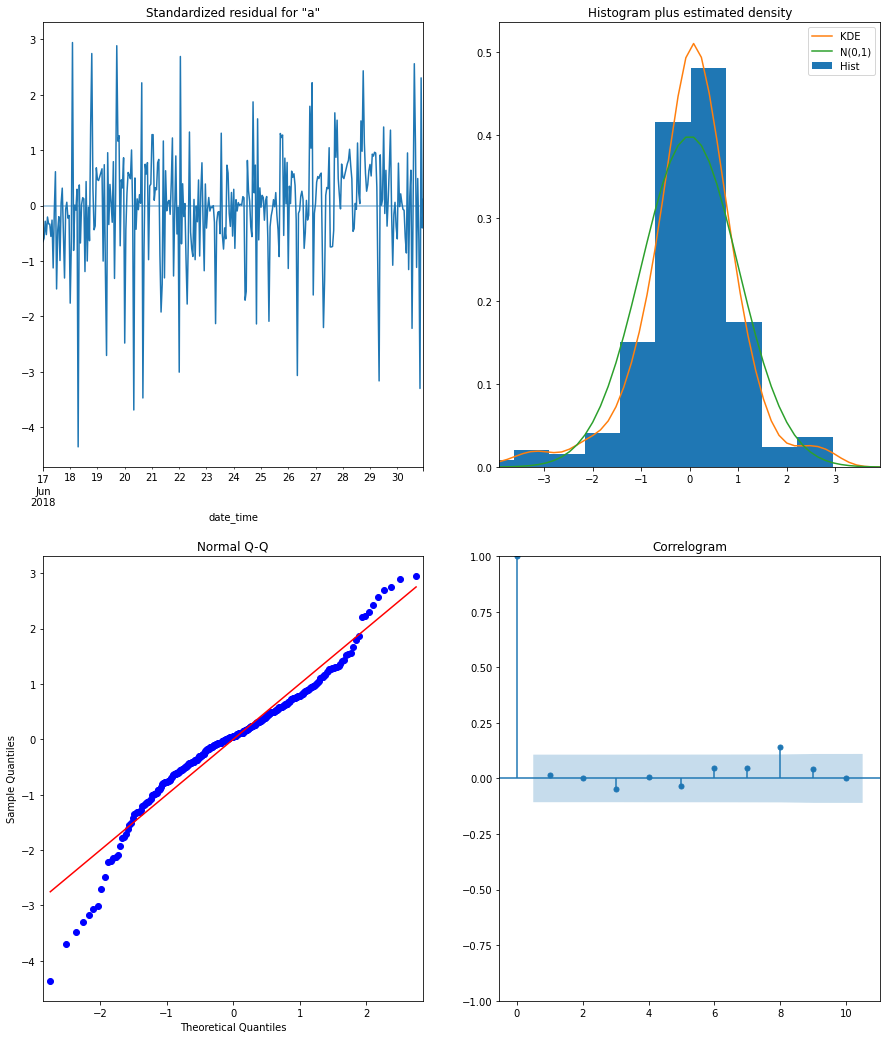

In [354]:
results.plot_diagnostics(figsize=(15,18))
plt.show()

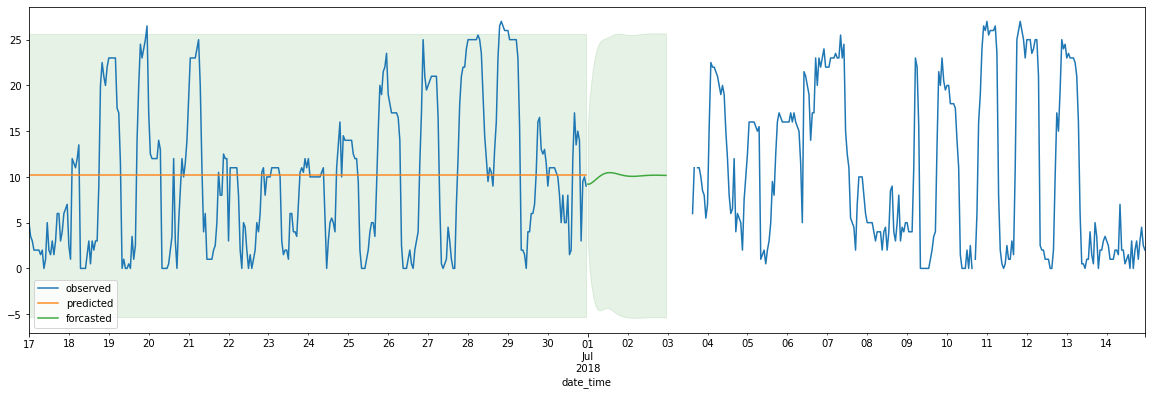

In [376]:
#get predictions

pred = results.get_prediction(start=pd.to_datetime('2018-06-17'),dynamic=True,full_results=True)
pred_conf = pred.conf_int()

forcast = results.get_forecast(steps=48)
for_conf = forcast.conf_int()

rcParams['figure.figsize'] = 20, 6

ax = ex_ts_station.avail_bikes_ts()['2018-06-17':'2018-07-14'].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='predicted',alpha=0.9)
forcast.predicted_mean.plot(ax=ax, label='forcasted', alpha=0.9)

ax.fill_between(pred_conf.index,
               pred_conf.iloc[:, 0],
               pred_conf.iloc[:,1], color='g',alpha=0.1)
ax.fill_between(for_conf.index,
               for_conf.iloc[:, 0],
               for_conf.iloc[:,1], color='g',alpha=0.1)


plt.legend();

In [373]:
forcast

In [21]:
def search_station_id(query):
    """
    Returns station ids given a particular string as query
    """
    return current_df.loc[current_df.station_name.str.contains(query)][['station_name','station_id']]

In [23]:
search_station_id('42')

,station_name,station_id
241,W 42 St & 8 Ave,529
411,W 42 St & Dyer Ave,3236
812,W 42 St & 6 Ave,3785
940,E 142 St & 3 Ave,3930
941,Morris Ave & E 142 St,3931
1057,Southern Blvd & E 142 St,4064


In [289]:
class Station(object):
    
    def __init__(self, station_id):
        self.id = station_id
        self.name = current_df.loc[df.station_id == station_id].station_name.values[0]
        self.ts_starts = ts_starts_df.loc[int(station_id)]
        self.ts_ends = ts_ends_df.loc[int(station_id)]
        self.ts_bikes = ts_stations.loc[int(station_id)]
        self.lat = current_df.loc[df.station_id == station_id].lat.values[0]
        self.lon = current_df.loc[df.station_id == station_id].lon.values[0]
        self.capacity = current_df.loc[df.station_id == station_id].capacity.values[0]
        self.station_type = current_df.loc[df.station_id == station_id].station_type.values[0]
        self.legacy_id = current_df.loc[df.station_id == station_id].legacy_id_x.values[0]
        self.has_kiosk = current_df.loc[df.station_id == station_id].has_kiosk.values[0]
        self.region_id = current_df.loc[df.station_id == int(station_id)].region_id.values[0]
        self.region_name = regions[self.region_id]
        self.current_avail_bikes = current_df.loc[df.station_id == station_id].num_bikes_available.values[0]
        self.current_disabled_bikes = current_df.loc[df.station_id == station_id].num_bikes_disabled.values[0]
        self.current_avail_docks = current_df.loc[df.station_id == station_id].num_docks_available.values[0]
        self.current_disabled_docks = current_df.loc[df.station_id == station_id].num_docks_disabled.values[0]
        self.status = current_df.loc[df.station_id == station_id].station_status.values[0]
        self.rental_methods = current_df.loc[df.station_id == station_id].rental_methods.values[0]
        self.last_update = dt.datetime.fromtimestamp(current_df.loc[df.station_id == station_id].last_reported.values[0])
        
    
    def info(self):
        """
        Prints basic station stats
        """
        print(f"""
        #### Station {self.id} Info ####
        
        Name: {self.name}
        Status: {self.status}
        Legacy ID: {self.legacy_id}
        Type: {self.station_type}
        Region: {self.region_name} 
        Coordinates: ({self.lat},{self.lon})
        Rental Methods: {self.rental_methods}
        Has Kiosk: {self.has_kiosk}
        
        #### Bike Stats ####
        
        As of: {self.last_update}
        Capacity: {self.capacity}
        Available Bikes: {self.current_avail_bikes}
        Available Docks: {self.current_avail_docks}
        Disabled Bikes: {self.current_disabled_bikes}
        Disabled Docks: {self.current_disabled_docks}
        """)
    
    def net_bikes_ts(self, resample='H'):
        """
        Returns a pandas Time Series of net bikes in/out per resample time period
        Positive value indicates net gain of bikes over resample time period 
        Negative value indicates net loss of bikes over resample time period
        
        ---Params---
    
        resample: str, pandas date offset string, defaults to hourly ('H')
                    https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects 
        """
        return self.ts_ends.resample(resample).tripduration.count() \
            - self.ts_starts.resample(resample).tripduration.count()
    
    def avail_bikes_ts(self, resample='H'):
        """
        Returns a pandas Time Series of average available bikes at station per resample time period
        
        ---Params---
        
        resample: str, pandas date offset string, defaults to hourly ('H')
                    https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects 
        """
        return ts_stations.loc[self.id].avail_bikes.resample(resample).mean()   
    
    def plot_net_bikes(self, resample='H', time_interval=None):
        """
        Plots the Net Bikes in/out of a station over a given time interval by resample size
        Positive value indicates net gain of bikes over resample time period 
        Negative value indicates net loss of bikes over resample time period
        
        ---Params---
        
        resample: str, pandas date offset string, defaults to hourly ('H')
                    https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects 

        time_interval: ('YYYY-MM-DD HH:MM','YYYY-MM-DD HH:MM'), tuple of 2 strings, if None defaults to entire time series
        """
        station_net = self.net_bikes_ts(resample)
        fig, ax = plt.subplots(figsize=(10,5))
        if time_interval == None:
            ax.plot(station_net)
            ax.set_title(f'Net Bikes ({resample})\nStation {self.id}: {self.name}')
            return ax
        else:
            ax.plot(station_net[time_interval[0]:time_interval[1]])
            ax.set_title(f'Net Bikes ({resample})\nStation {self.id}: {self.name}')
            return ax
            
    def plot_avail_bikes(self,resample='H',time_interval=None):
        """
        Plots the total average Bikes available at a station over a given time interval by resample size
        
        ---Params---

        resample: str, pandas date offset string, defaults to hourly ('H')
                    https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects 

        time_interval: ('YYYY-MM-DD HH:MM','YYYY-MM-DD HH:MM'), tuple of 2 strings, if None defaults to entire time series
        """
        station_net = self.avail_bikes_ts(resample)
        fig, ax = plt.subplots(figsize=(10,5))
        if time_interval == None:
            ax.plot(station_net)
            ax.set_title(f'Total Bikes ({resample})\nStation {self.id}: {self.name}')
            return ax
        else:
            ax.plot(station_net[time_interval[0]:time_interval[1]])
            ax.set_title(f'Total Bikes ({resample})\nStation {self.id}: {self.name}')
            return ax
        
    def availbike_stationarity(self,resample='H',time_interval=None, window = 6):
        """
        Checks the stationarity of time series with rolling mean, rolling std and dickey fuller test
        
        ---Params---
        
        resample: str, pandas date offset string, defaults to hourly ('H')
                    https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects 

        time_interval: tuple of 2 strings, ('YYYY-MM-DD HH:MM','YYYY-MM-DD HH:MM'), if None defaults to entire time series
        
        window: int, window used in rolling calculation
        """
        if time_interval == None:
            ts = self.avail_bikes_ts(resample=resample)
        else:
            ts = self.avail_bikes_ts(resample=resample)[time_interval[0]:time_interval[1]]
        
        #Plot time series, rolling mean, rolling std
        roll_mean = ts.rolling(window=window).mean()
        roll_std = ts.rolling(window=window).std()
        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(ts);
        ax.plot(roll_mean)
        ax.plot(roll_std)
        ax.legend(['Time Series','Roll Mean','Roll STD'])
        
        #Dickey Fuller
        dftest = adfuller(ts)

        # Extract and display test results
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
    
        print ('Dickey-Fuller test: \n')
        print(dfoutput)
        
        if dfoutput['p-value'] < .05:
            print(f'\nStationary: p-value {dfoutput["p-value"]} < 0.05')
        else:
           print(f'\nNot Stationary: p-value {dfoutput["p-value"]} > 0.05')
               
        return roll_mean, roll_std, ax, dfoutput
    
    def availbike_decompose(self, resample='H',time_interval=None):
        """
        Performs decompostion of Available Bikes time seres
        
        ---Params---
        
        resample: str, pandas date offset string, defaults to hourly ('H')
                https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects 

        time_interval: tuple of 2 strings, ('YYYY-MM-DD HH:MM','YYYY-MM-DD HH:MM'), if None defaults to entire time series
        """
        if time_interval == None:
            ts = self.avail_bikes_ts(resample=resample)
        else:
            ts = self.avail_bikes_ts(resample=resample)[time_interval[0]:time_interval[1]]
            
        decomposition = seasonal_decompose(ts)

        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residuals = decomposition.resid
        
        plt.figure(figsize=(12,8))
        plt.subplot(411)
        plt.plot(ex_time_series,label='Original',color='blue')
        plt.legend(loc='upper left')
        plt.subplot(412)
        plt.plot(trend,label='Trend',color='green')
        plt.legend(loc='upper left')
        plt.subplot(413)
        plt.plot(seasonal,label='Seasonal',color='orange')
        plt.legend(loc='upper left')
        plt.subplot(414)
        plt.plot(residuals,label='Residuals',color='red')
        plt.legend(loc='upper left')
        
        return decomposition

    def netbike_stationarity(self,resample='H',time_interval=None, window = 6):
        """
        Checks the stationarity of net bike time series with rolling mean, rolling std and dickey fuller test
        
        ---Params---
        
        resample: str, pandas date offset string, defaults to hourly ('H')
                https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects 

        time_interval: tuple of 2 strings, ('YYYY-MM-DD HH:MM','YYYY-MM-DD HH:MM'), if None defaults to entire time series
        
        window: int, window used in rolling calculation
        """
        if time_interval == None:
            ts = self.net_bikes_ts(resample=resample)
        else:
            ts = self.net_bikes_ts(resample=resample)[time_interval[0]:time_interval[1]]
        
        #Plot time series, rolling mean, rolling std
        roll_mean = ts.rolling(window=window).mean()
        roll_std = ts.rolling(window=window).std()
        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(ts);
        ax.plot(roll_mean)
        ax.plot(roll_std)
        ax.legend(['Time Series','Roll Mean','Roll STD'])
        
        #Dickey Fuller
        dftest = adfuller(ts)

        # Extract and display test results
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
    
        print ('Dickey-Fuller test: \n')
        print(dfoutput)
        
        if dfoutput['p-value'] < .05:
            print(f'\nStationary: p-value {dfoutput["p-value"]} < 0.05')
        else:
           print(f'\nNot Stationary: p-value {dfoutput["p-value"]} > 0.05')
               
        return roll_mean, roll_std, ax, dfoutput
    
    def netbike_decompose(self, resample='H',time_interval=None):
        """
        Performs decompostion of Available Bikes time seres
        
        ---Params---
        
        resample: str, pandas date offset string, defaults to hourly ('H')
                https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects 

        time_interval: tuple of 2 strings, ('YYYY-MM-DD HH:MM','YYYY-MM-DD HH:MM'), if None defaults to entire time series
        """
        if time_interval == None:
            ts = self.net_bikes_ts(resample=resample)
        else:
            ts = self.net_bikes_ts(resample=resample)[time_interval[0]:time_interval[1]]
            
        decomposition = seasonal_decompose(ts)

        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residuals = decomposition.resid
        
        plt.figure(figsize=(12,8))
        plt.subplot(411)
        plt.plot(ex_time_series,label='Original',color='blue')
        plt.legend(loc='upper left')
        plt.subplot(412)
        plt.plot(trend,label='Trend',color='green')
        plt.legend(loc='upper left')
        plt.subplot(413)
        plt.plot(seasonal,label='Seasonal',color='orange')
        plt.legend(loc='upper left')
        plt.subplot(414)
        plt.plot(residuals,label='Residuals',color='red')
        plt.legend(loc='upper left')
        
        return decomposition     
    
    def update_bikes(self):
        """
        Updates bike & dock status at stations and returns new bike df
        """
        df = station_initalize()
        self.current_avail_bikes = df.loc[df.station_id == self.id].num_bikes_available
        self.current_disabled_bikes = df.loc[df.station_id == self.id].num_bikes_available
        self.current_avail_docks = df.loc[df.station_id == self.id].num_docks_available
        self.current_disabled_docks = df.loc[df.station_id == self.id].num_docks_disabled
        return df

In [249]:
df.loc[df.station_id == 72].station_name.values[0]

'W 52 St & 11 Ave'

In [208]:
test = Station(72)

In [209]:
test.info()


        #### Station 72 Info ####
        
        Name: W 52 St & 11 Ave
        Status: active
        Legacy ID: 72
        Type: classic
        Region: NYC District 
        Coordinates: (40.76727216,-73.99392888)
        Rental Methods: ['CREDITCARD', 'KEY']
        Has Kiosk: True
        
        #### Bike Stats ####
        As of: 2020-12-04 21:49:15
        Capacity: 55
        Available Bikes: 11
        Available Docks: 44
        Disabled Bikes: 0
        Disabled Docks: 0
        


        


In [17]:
heydt_df = pd.read_csv('./station_data/citibike-export/station_snapshots_20180920.csv')

In [70]:
heydt_df.head()

,id,station_id,status,available_bike_count,available_dock_count,created_at,station_summary_id
0,1,1,Active,10,21,2013-07-10 23:13:54.617721,1
1,2,2,Active,10,23,2013-07-10 23:13:54.630741,1
2,3,3,Active,13,12,2013-07-10 23:13:54.641206,1
3,4,4,Active,23,39,2013-07-10 23:13:54.651597,1
4,5,5,Active,2,33,2013-07-10 23:13:54.662174,1


In [71]:
heydt_stations = pd.read_csv('./station_data/citibike-export/station_summaries_20180920.csv')

In [75]:
heydt_stations.sort_values('total_stations',ascending=False)

,id,active_stations,total_stations,created_at,updated_at,last_update
183970,183971,804,816,2018-09-20 04:00:05.659102,2018-09-20 04:00:05.659102,1537416002
183911,183912,653,812,2017-09-06 12:31:17.43519,2017-09-06 12:31:17.43519,1504701075
183882,183883,654,812,2017-09-06 07:41:09.636133,2017-09-06 07:41:09.636133,1504683667
183883,183884,654,812,2017-09-06 07:51:13.818383,2017-09-06 07:51:13.818383,1504684270
183884,183885,654,812,2017-09-06 08:01:09.947489,2017-09-06 08:01:09.947489,1504684867
...,...,...,...,...,...,...
39337,39338,0,0,2014-04-11 21:40:04.164419,2014-04-11 21:40:04.164419,1397252102
25134,25135,0,0,2014-01-03 05:40:04.594761,2014-01-03 05:40:04.594761,1388727592
25135,25136,0,0,2014-01-03 05:50:05.293982,2014-01-03 05:50:05.293982,1388728184
25136,25137,0,0,2014-01-03 06:00:04.485996,2014-01-03 06:00:04.485996,1388728803


In [39]:
tyndall_df = pd.read_csv('./station_data/drive-download-20201119T051325Z-001/bikeshare_nyc_raw.csv',delimiter='\t')

In [54]:
tyndall_df.sort_values('date').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507296 entries, 0 to 209704
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   dock_id      507296 non-null  int64         
 1   dock_name    507296 non-null  object        
 2   date         507296 non-null  object        
 3   hour         507296 non-null  int64         
 4   minute       507296 non-null  int64         
 5   pm           507296 non-null  object        
 6   avail_bikes  507296 non-null  int64         
 7   avail_docks  507296 non-null  int64         
 8   tot_docks    507296 non-null  int64         
 9   _lat         507296 non-null  float64       
 10  _long        507296 non-null  float64       
 11  in_service   507296 non-null  int64         
 12  status_key   507296 non-null  int64         
 13  date_time    507296 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(8), object(3)
memory usage: 58.1+ MB


In [41]:
tyndall_df.pm = np.where(tyndall_df.pm == 1, 'PM','AM')
tyndall_df.pm.value_counts()

PM    256968
AM    250328
Name: pm, dtype: int64

In [43]:
tyndall_df['date_time'] = tyndall_df.apply(lambda x: x['date'] + " " + str(x['hour']) + ":" + str(x['minute']) + x['pm'],axis=1)

In [45]:
tyndall_df.date_time = pd.to_datetime(tyndall_df.date_time, format='%y-%m-%d %I:%M%p') 

In [65]:
tyndall_df.groupby('dock_id').get_group(3307).sort_values('date_time')

,dock_id,dock_name,date,hour,minute,pm,avail_bikes,avail_docks,tot_docks,_lat,_long,in_service,status_key,date_time
366773,3307,West End Ave & W 94 St,19-04-02,4,56,PM,1,30,31,40.794165,-73.974124,1,1,2019-04-02 16:56:00
366774,3307,West End Ave & W 94 St,19-04-02,5,36,PM,0,31,31,40.794165,-73.974124,1,1,2019-04-02 17:36:00
366775,3307,West End Ave & W 94 St,19-04-02,6,16,PM,4,27,31,40.794165,-73.974124,1,1,2019-04-02 18:16:00
366776,3307,West End Ave & W 94 St,19-04-02,6,54,PM,6,25,31,40.794165,-73.974124,1,1,2019-04-02 18:54:00
366777,3307,West End Ave & W 94 St,19-04-02,7,36,PM,10,21,31,40.794165,-73.974124,1,1,2019-04-02 19:36:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367531,3307,West End Ave & W 94 St,19-04-30,2,14,PM,0,31,31,40.794165,-73.974124,1,1,2019-04-30 14:14:00
367532,3307,West End Ave & W 94 St,19-04-30,3,3,PM,1,30,31,40.794165,-73.974124,1,1,2019-04-30 15:03:00
367533,3307,West End Ave & W 94 St,19-04-30,3,53,PM,1,30,31,40.794165,-73.974124,1,1,2019-04-30 15:53:00
367534,3307,West End Ave & W 94 St,19-04-30,4,42,PM,1,30,31,40.794165,-73.974124,1,1,2019-04-30 16:42:00


In [69]:
t = pd.read_csv('./trip_data/201906-citibike-tripdata.csv')

In [27]:
#tynall is open bus
tyndall_df2 = pd.read_csv('./station_data/drive-download-20201119T051325Z-001/empty_full_results.csv')

In [28]:
tyndall_df2.head(1000)

,dock_name,dock_id,percent_empty,percent_full
0,1 Ave & E 16 St,504,5.536332,1.730104
1,1 Ave & E 18 St,2003,9.169550,13.148790
2,1 Ave & E 30 St,536,8.650519,5.190311
3,1 Ave & E 44 St,455,14.186850,5.017301
4,NaN,489,NaN,NaN
...,...,...,...,...
753,E 102 St & 1 Ave,3351,2.249135,18.339100
754,India St & West St,3469,0.692041,16.609000
755,West End Ave & W 94 St,3307,15.916950,1.903114
756,Devoe St & Lorimer St,3453,5.363322,1.903114
